In [1]:
#Original code: https://www.kaggle.com/gbellport/pneumonia-detection-96-recall-91-accuracy/output
#Code modified by Jordan Bennett , and converted from .pynb to .py using https://jupyter.org/try

######################
# Jordan's modifications : 
#1. Pneumonia model training components removed. (Saved weight loading takes place instead)
#2. Covid19 training components added, atop pretrained model in (1).
#3. Replace pyplot -> plt.imread, with  gray scale cv2.imread(path,0), so that ui's image load process doesn't throw a pyimage10 error
#4. Other pyplot related code removed.
#5. Confusion Matrix Format added, as quick explanation of Confusion Matrix that was already included.
#6. Specificty calculation and relevant label added.
#7. Many other modifications


# General libraries
import os
import numpy as np
import random
import cv2



# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [2]:
#################################
#GLOBAL UTILITY
##Serves both Section B: "regular pneumonia..." and Section D: "covid19 pneumonia..." accuracy report sections.



# Hyperparameters
img_dims = 150
batch_size = 32



###########
#Util Component 1: Confusion matrix report/Accuracy measures
from sklearn.metrics import accuracy_score, confusion_matrix

#For graphical confusion metric
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
def renderConfusionMetrics ( ___model, _testData, _testLabels, enableTraining, ___train_gen, ___test_gen, __batch_size, __epochs, hdf5_testSaveFileName ):
    preds = ___model.predict(_testData)

    acc = accuracy_score(_testLabels, np.round(preds))*100
    cm = confusion_matrix(_testLabels, np.round(preds))
    tn, fp, fn, tp = cm.ravel()

    plt.style.use("grayscale")
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues_r')
    plt.show()

    print('\nCONFUSION MATRIX FORMAT ------------------\n')
    print("[true positives    false positives]")
    print("[false negatives    true negatives]\n\n")

    print('CONFUSION MATRIX ------------------')
    print(cm)

    print('\nTEST METRICS ----------------------')
    precision = tp/(tp+fp)*100
    recall = tp/(tp+fn)*100
    specificity = tn/(tn+fp)*100 #Jordan_note: added specificity calculation 
    print('Accuracy: {}%'.format(acc))
    print('Precision: {}%'.format(precision))
    print('Recall/Sensitivity: {}%'.format(recall)) #Jordan_note: added sensitivity label
    print('Specificity {}%'.format(specificity)) #Jordan_note: added specificity calculation 
    print('F1-score: {}'.format(2*precision*recall/(precision+recall)))


    if enableTraining:
        checkpoint = ModelCheckpoint(filepath=hdf5_testSaveFileName, save_best_only=True, save_weights_only=True)
        lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


        hist = ___model.fit_generator(
                   ___train_gen, steps_per_epoch=___test_gen.samples // __batch_size, 
                   epochs=__epochs, validation_data=___test_gen, 
                   validation_steps=___test_gen.samples // __batch_size, callbacks=[checkpoint, lr_reduce])

        print('\nTRAIN METRIC ----------------------')
        print('Covid19 Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))


In [4]:
def defineModelArchitecture (_img_dims ):
    # Input layer
    inputs = Input(shape=(_img_dims, _img_dims, 3))

    # First conv block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Second conv block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Third conv block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Fourth conv block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # Fifth conv block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # FC layer
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.7)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)

    # Output layer
    output = Dense(units=1, activation='sigmoid')(x)
    
    return inputs, output



In [5]:
###########
#Util Component 3: Data processor
#Note: This process does not use validation path, because validation path in the original competion reasonably had too little data (8 samples) to create any insight.
# the "directoryProcessArray" param from "reportFileDistributions" function corresponds to the hard-coded sub-directories of train and test, excluding val.
def process_data(___inputPath, img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=___inputPath+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=___inputPath+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(___inputPath + 'test' + cond)):
            img = cv2.imread(___inputPath+'test'+cond+img,0) #Replace plt.imread, with  gray scale cv2.imread(path,0), so that ui's image load process doesn't throw a pyimage10 error
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels
    

In [6]:
###########
#Util Component 4: Report file distributions
#directoryProcessArray eg, = ['train', 'val', 'test'], in the case that training val and test folders exist in sub-dir for processing.
def reportFileDistributions (___inputPath, directoryProcessArray ):
    for _set in directoryProcessArray:
        n_normal = len(os.listdir(___inputPath + _set + '/NORMAL'))
        n_infect = len(os.listdir(___inputPath + _set + '/PNEUMONIA'))
        print('Set: {}, normal images: {}, illness-positive images: {}'.format(_set, n_normal, n_infect))



In [7]:
########################################################################
# disabling warnings
import logging
logging.getLogger('tensorflow').disabled = True #Jordan_note: Disable red warning lines seen at model architecture creation.

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)



########################################################################
#SECTION A: MODEL ARCHITECTURE NON-COVID19 PNEUMONIA DETECTOR

inputs, output = defineModelArchitecture ( img_dims )

# Creating model and compiling
model_pneumoniaDetector = Model(inputs=inputs, outputs=output)
model_pneumoniaDetector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_pneumoniaDetector.load_weights('best_weights.hdf5')

########################################################################
#SECTION B: NON-COVID19  PNEUMONIA VS NORMAL LUNG ACCURACY REPORT [LOADED MODEL/WEIGHTS]
print('\n\n#######TRAINED NON-COVID19 PNEUMONIA VS NORMAL LUNG TEST REPORT [LOADED MODEL/WEIGHTS]')
# Lets first look at some of our X-ray images and how each dataset is distributed:

input_path_b = 'xray_dataset/'

# Report file distributions
reportFileDistributions (input_path_b, ['train', 'val', 'test'] )

# Getting the data
train_gen, test_gen, test_data_b, test_labels_b = process_data(input_path_b, img_dims, batch_size)

# Reporting on accuracies
#renderConfusionMetrics ( model_pneumoniaDetector, test_data_b, test_labels_b, False, None, None, None, None, None )



########################################################################
#SECTION C: MODEL ARCHITECTURE COVID19 DETECTOR

inputs, output = defineModelArchitecture ( img_dims )


# Creating model and compiling
model_covid19PneumoniaDetector = Model(inputs=inputs, outputs=output)
model_covid19PneumoniaDetector.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_covid19PneumoniaDetector.load_weights('covid19_neural_network_weights_jordan.hdf5')


###################################################################
#SECTION D: COVID19 PNEUMONIA VS NORMAL LUNG ACCURACY REPORT [LOADED MODEL/WEIGHTS]
print('\n\n#######TRAINED COVID19 PNEUMONIA VS NORMAL LUNG TEST REPORT [LOADED MODEL/WEIGHTS]')
      
#Jordan_note establish custom_path for covid 19 test data
input_path_d = 'xray_dataset_covid19/'


# Report file distributions
reportFileDistributions (input_path_d, ['train', 'test'])

# Getting the data
train_gen_d, test_gen_d, test_data_d, test_labels_d = process_data(input_path_d, img_dims, batch_size)

# Reporting on accuracies
#renderConfusionMetrics ( model_covid19PneumoniaDetector, test_data_d, test_labels_d, False, train_gen_d, test_gen_d, batch_size, 11, 'covid19_neural_network_weights_jordan_v2.hdf5' )








model_pneumoniaDetector = model_pneumoniaDetector
model_covid19PneumoniaDetector = model_covid19PneumoniaDetector


# model_covid19PneumoniaDetector.sa



#######TRAINED NON-COVID19 PNEUMONIA VS NORMAL LUNG TEST REPORT [LOADED MODEL/WEIGHTS]
Set: train, normal images: 20, illness-positive images: 20
Set: val, normal images: 7, illness-positive images: 8
Set: test, normal images: 18, illness-positive images: 17
Found 40 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


#######TRAINED COVID19 PNEUMONIA VS NORMAL LUNG TEST REPORT [LOADED MODEL/WEIGHTS]
Set: train, normal images: 74, illness-positive images: 74
Set: test, normal images: 20, illness-positive images: 20
Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [8]:
# import covid19_ai_diagnoser_optimal_model_architecture


# model_pneumoniaDetector = covid19_ai_diagnoser_optimal_model_architecture.model_pneumoniaDetector
# model_covid19PneumoniaDetector = covid19_ai_diagnoser_optimal_model_architecture.model_covid19PneumoniaDetector

# DIAGNOSIS_MESSAGES = [ "Pneumonia detected", "Covid19 detected", "Normal lungs detected" ]

# ###########################
# #Function written by Jordan to do online inference i.e. Regular Pneumonia tests
def doOnlineInference_regularPneumonia (imagePath):
    test_data = []
    img = cv2.imread(imagePath,0) #Replace plt.imread, with  gray scale cv2.imread(path,0), so that ui's image load process doesn't throw a pyimage10 error
    img = cv2.resize(img, (img_dims, img_dims))
    img = np.dstack([img, img, img])
    img = img.astype('float32') / 255
    test_data.append(img)
    prediction = model_pneumoniaDetector.predict(np.array(test_data))
    _prediction = round( prediction[0][0]*100, 3 )
    if ( _prediction > 50 ):
        _prediction = DIAGNOSIS_MESSAGES[0];
    elif ( _prediction < 50 ):
        _prediction = DIAGNOSIS_MESSAGES[2];  
    outputContent = _prediction + "\n"
    outputContent += "Raw Neural Network Output : " + str(prediction[0][0]) + ". A value closer to 1 signifies illness, while a value closer to 0 signifies normalness.\n\n"
    recordInferenceEvent (imagePath, outputContent)
    return outputContent


#Function written by Jordan to do online inference i.e. Covid19 tests
def doOnlineInference_covid19Pneumonia (imagePath):
    test_data = []
    img = cv2.imread(imagePath,0) #Replace plt.imread, with  gray scale cv2.imread(path,0), so that ui's image load process doesn't throw a pyimage10 error
    img = cv2.resize(img, (img_dims, img_dims))
    img = np.dstack([img, img, img])
    img = img.astype('float32') / 255
    test_data.append(img)
    prediction = model_covid19PneumoniaDetector.predict(np.array(test_data))
    _prediction = round( prediction[0][0]*100, 3 )
    if ( _prediction > 50 ):
        _prediction = DIAGNOSIS_MESSAGES[1];
    elif ( _prediction < 50 ):
        _prediction = DIAGNOSIS_MESSAGES[2];  
    outputContent = _prediction + "\n"
    outputContent += "Raw Neural Network Output : " + str(prediction[0][0]) + ". A value closer to 1 signifies illness, while a value closer to 0 signifies normalness.\n\n"
    recordInferenceEvent (imagePath, outputContent)
    return outputContent



# #Record each inference in a text file 
# import datetime
# def recordInferenceEvent ( imagePath, outputContent ):
#     currentDate = datetime.datetime.now()
#     with open("inference_record.txt", "a") as text_file:
#         text_file.write("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
#         text_file.write("DATE/TIME : " + str(currentDate.month) + " " + str(currentDate.day) + ", " + str(currentDate.year) + "..." + str(currentDate.hour) + ":" + str(currentDate.minute) + ":" + str(currentDate.second) + "\n\n") 
#         text_file.write("IMAGE : " + imagePath + "\n\n")
#         text_file.write("RESULT : \n" + outputContent + "\n\n\n\n")


# """
# NORMAL SAMPLES:
# doOnlineInference_regularPneumonia("xray_dataset/val/NORMAL/NORMAL2-IM-1430-0001.jpeg")
# doOnlineInference_regularPneumonia("xray_dataset/val/NORMAL/NORMAL2-IM-1427-0001.jpeg")

# PNEUMONIA SAMPLES:
# doOnlineInference_regularPneumonia("xray_dataset/val/PNEUMONIA/person1946_bacteria_4875.jpeg")
# doOnlineInference_regularPneumonia("xray_dataset/val/PNEUMONIA/person1950_bacteria_4881.jpeg")

# ACTUAL CORONAVIRUS SAMPLES:
# doOnlineInference_covid19Pneumonia("coronavirus_positive_WeifangKong_et-al.jpg")
# doOnlineInference_covid19Pneumonia("coronavirus_positive_day7_of_infection_UPSCALED.jpg")
# """





#######TRAINED NON-COVID19 PNEUMONIA VS NORMAL LUNG TEST REPORT [LOADED MODEL/WEIGHTS]
Set: train, normal images: 20, illness-positive images: 20
Set: val, normal images: 7, illness-positive images: 8
Set: test, normal images: 18, illness-positive images: 17
Found 40 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


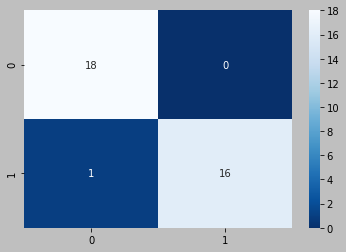


CONFUSION MATRIX FORMAT ------------------

[true positives    false positives]
[false negatives    true negatives]


CONFUSION MATRIX ------------------
[[18  0]
 [ 1 16]]

TEST METRICS ----------------------
Accuracy: 97.14285714285714%
Precision: 100.0%
Recall/Sensitivity: 94.11764705882352%
Specificity 100.0%
F1-score: 96.96969696969695


#######TRAINED COVID19 PNEUMONIA VS NORMAL LUNG TEST REPORT [LOADED MODEL/WEIGHTS]
Set: train, normal images: 74, illness-positive images: 74
Set: test, normal images: 20, illness-positive images: 20
Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


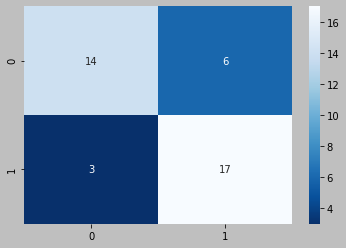


CONFUSION MATRIX FORMAT ------------------

[true positives    false positives]
[false negatives    true negatives]


CONFUSION MATRIX ------------------
[[14  6]
 [ 3 17]]

TEST METRICS ----------------------
Accuracy: 77.5%
Precision: 73.91304347826086%
Recall/Sensitivity: 85.0%
Specificity 70.0%
F1-score: 79.06976744186045


In [9]:
import covid19_ai_diagnoser
import sys
from PIL import Image, ImageTk

import os
import codecs



import cv2

CONSTANT_DIAGNOSIS_IMAGE_SPAN = 480

DIAGNOSIS_RESULT = ""
DIAGNOSIS_RESULT_FIELD = None
#Jordan_note: Added to facilitate output window data




def loadRegularPneumoniaImageFromName(filename):

    load = Image.open(filename)
    load = load.resize((CONSTANT_DIAGNOSIS_IMAGE_SPAN, CONSTANT_DIAGNOSIS_IMAGE_SPAN),Image.ANTIALIAS) #Resized "load" image to constant size on screen. However, neural network still runs on on original image scale from filename.


    DIAGNOSIS_RESULT=doOnlineInference_regularPneumonia (filename)
    print(DIAGNOSIS_RESULT)


    


def loadCovid19ImageFromName(filename):

    load = Image.open(filename)
    load = load.resize((CONSTANT_DIAGNOSIS_IMAGE_SPAN, CONSTANT_DIAGNOSIS_IMAGE_SPAN),Image.ANTIALIAS) #Resized "load" image to constant size on screen. However, neural network still runs on on original image scale from filename.
    
    DIAGNOSIS_RESULT = covid19_ai_diagnoser.doOnlineInference_covid19Pneumonia (filename)
    print(DIAGNOSIS_RESULT)



In [11]:
loadCovid19ImageFromName('COVID.jpg')

Normal lungs detected
Raw Neural Network Output : 0.04699881. A value closer to 1 signifies illness, while a value closer to 0 signifies normalness.


